In [1]:
from kmer_counting import sequence2matrix
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import copy
from typing import List
import tqdm
from sklearn.model_selection import train_test_split
import imblearn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torcheval.metrics import MulticlassAccuracy

from torchinfo import summary

In [2]:
class detection_model(nn.Module):
    def __init__(self):
        super(detection_model, self).__init__()

        #Defining the layers
        self.layer1 = nn.Linear(256, 64, bias=True)
        self.activationlayer1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(64, 64, bias=True)
        self.activationlayer2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(64, 32, bias=True)
        self.activationlayer3 = nn.LeakyReLU()
        self.layer4 = nn.Linear(32, 16, bias=True)
        self.activationlayer4 = nn.LeakyReLU()
        self.ouput = nn.Linear(16, 1, bias=True)
        # for classification
        self.outputactivation = nn.Sigmoid()
        # for predicition
        #self.outputactivation = nn.Hardtanh(min_val=min_val, max_val=max_val)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activationlayer1(x)
        x = self.layer2(x)
        x = self.activationlayer2(x)
        x = self.layer3(x)
        x = self.activationlayer3(x)
        x = self.layer4(x)
        x = self.activationlayer4(x)
        x = self.ouput(x)
        x = self.outputactivation(x)
        return x

In [3]:
class classification_model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(classification_model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim

        #Defining the layers
        self.dropoutlayer = nn.Dropout(0.5)
        self.layer1 = nn.Linear(input_size, hidden_dim, bias=True)
        self.activationlayer1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activationlayer2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activationlayer3 = nn.LeakyReLU()
        self.layer4 = nn.Linear(hidden_dim, int(hidden_dim/2), bias=True)
        self.activationlayer4 = nn.LeakyReLU()
        self.layer5= nn.Linear(int(hidden_dim/2), int(hidden_dim/4), bias=True)
        self.activationlayer5 = nn.LeakyReLU()
        self.ouput = nn.Linear(int(hidden_dim/4), output_size, bias=True)
        # for classification
        self.outputactivation = nn.LogSoftmax(dim=1)
        # for predicition
        #self.outputactivation = nn.Hardtanh(min_val=min_val, max_val=max_val)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer1(x)
        x = self.layer2(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer2(x)
        x = self.layer3(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer3(x)
        x = self.layer4(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer4(x)
        x = self.layer5(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer5(x)
        x = self.ouput(x)
        x = self.outputactivation(x)
        return x

In [7]:
df = pd.read_csv("test_data/classes.csv")
df

,type,strand
0,intergenic,GTGCAGTGTGCAGTGCAGGCTTGAACCTGCAGGGGTCCCCCAGGAG...
1,intergenic,AGACAGGAGGTCTCCCTACGTTATCTTGGCTGACTTCTAACTTCCG...
2,intergenic,AAATATTTCTATTAGGCCACTGCAAAAGTAACTGCAAAAACCACAA...
3,intergenic,CCATGCAGGGATCTGCCTTCCTGTGGAATGATCTCCAATGATCTTC...
4,intergenic,GGTCTCACTGTCGCCCAGGCTGAAGTGCAGTGGCGTGATCACGGCT...
...,...,...
3235,non_circular,GTGCTTGCTCCAGTAGCACATATTCTAAAATTGGAATGATACAGAG...
3236,non_circular,GTGCATACTTTGGCAGCACATATACTAAAATTGGAATGATACAGAG...
3237,non_circular,GGTCCTAAAGGAACATCTGATAAAATTAGAACGATATAAAGAAGAT...
3238,non_circular,GTGCTCGCTTCAGCAGCACATATACTAAAATTGGAACGATACAGAG...


In [8]:
X = df["strand"].values
y = df["type"].values
X.shape, y.shape

((3240,), (3240,))

In [142]:
converter = sequence2matrix(k_val=4)
matrix = converter.fit(X, save_dir="dataset/multiclass_data2")

In [ ]:
np.save("dataset/rna_vector_test", matrix)

### Testing Model

In [9]:
matrix = np.load("dataset/rna_vector_test.npy",allow_pickle=True)
new_X = []
new_y = []
for i, j in tqdm.tqdm(zip(matrix,y)):
    if i != 0:
        new_X.append([*i.values()])
        new_y.append(j)
new_X = np.array(new_X)
new_y = np.array(new_y)
new_X.shape, new_y.shape

3240it [00:00, 359978.41it/s]


((3238, 256), (3238,))

In [10]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print("using", device)
torch.backends.cudnn.benchmark = True

using cuda:0


In [11]:
tensor_x_train = torch.tensor(new_X).to(device)
#tensor_y_train = torch.tensor(y_train).to(device)

In [21]:
det_model = detection_model().to(device)
det_model.load_state_dict(torch.load("models\model_0\epoch_49"))
det_model_output = det_model(tensor_x_train.cuda().float())
det_model_output.shape

torch.Size([3238, 1])

In [37]:
model_path = "models\multiclass_model_0\epoch_x"
class_model = classification_model(256, 8, 2048).to(device)
class_model.load_state_dict(torch.load(model_path))
class_model_output = class_model(tensor_x_train.cuda().float())
class_model_output.shape

torch.Size([3238, 8])

In [38]:
det_converter = {
    "circ_rna": 0,
    "non_circ_rna":1
}
class_converter = {
    'BIRC6':0, 
    'MACF1':1, 
    'MALAT1':2, 
    'RYR2':3, 
    'SNHG14':4, 
    'TTN':5, 
    'USP34':6,
    'intergenic':7
}

In [39]:
inverse_class_converter = dict((v,k) for k,v in class_converter.items())
inverse_det_converter = dict((v,k) for k,v in det_converter.items())
inverse_det_converter

{0: 'circ_rna', 1: 'non_circ_rna'}

In [40]:
inverse_class_converter

{0: 'BIRC6',
 1: 'MACF1',
 2: 'MALAT1',
 3: 'RYR2',
 4: 'SNHG14',
 5: 'TTN',
 6: 'USP34',
 7: 'intergenic'}

In [41]:
y_true = new_y

In [42]:
res = []
for i,j,k in zip(y_true, det_model_output,class_model_output):
    true_label = i
    det_label = 0 if abs(1-j.item()) > abs(j.item()-0) else 1
    det_label = inverse_det_converter[det_label]
    class_label = inverse_class_converter[torch.argmax(k).item()]
    if det_label == "non_circ_rna":
        res.append("non_circular")
    else:
        res.append(class_label)

In [43]:
from sklearn import metrics

In [44]:
y_true.shape

(3238,)

In [45]:
import seaborn as sns

In [46]:
confussion_matrix = metrics.confusion_matrix(y_true, res)

<Axes: >

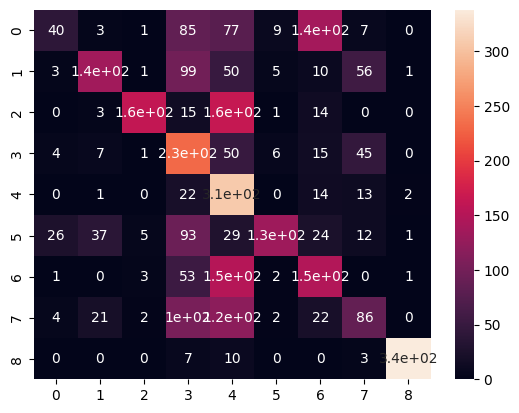

In [47]:
sns.heatmap(metrics.confusion_matrix(y_true, res), annot=True)

In [48]:
print(metrics.classification_report(y_true, res))

              precision    recall  f1-score   support

       BIRC6       0.51      0.11      0.18       360
       MACF1       0.65      0.38      0.48       360
      MALAT1       0.93      0.45      0.61       360
        RYR2       0.33      0.64      0.43       360
      SNHG14       0.32      0.86      0.47       360
         TTN       0.84      0.37      0.51       360
       USP34       0.39      0.41      0.40       360
  intergenic       0.39      0.24      0.30       360
non_circular       0.99      0.94      0.96       358

    accuracy                           0.49      3238
   macro avg       0.59      0.49      0.48      3238
weighted avg       0.59      0.49      0.48      3238



In [49]:
data = metrics.classification_report(y_true, res, output_dict=True)
data

{'BIRC6': {'precision': 0.5128205128205128,
  'recall': 0.1111111111111111,
  'f1-score': 0.182648401826484,
  'support': 360.0},
 'MACF1': {'precision': 0.6521739130434783,
  'recall': 0.375,
  'f1-score': 0.4761904761904762,
  'support': 360.0},
 'MALAT1': {'precision': 0.9257142857142857,
  'recall': 0.45,
  'f1-score': 0.6056074766355141,
  'support': 360.0},
 'RYR2': {'precision': 0.3267605633802817,
  'recall': 0.6444444444444445,
  'f1-score': 0.43364485981308415,
  'support': 360.0},
 'SNHG14': {'precision': 0.32116788321167883,
  'recall': 0.8555555555555555,
  'f1-score': 0.4670204700530705,
  'support': 360.0},
 'TTN': {'precision': 0.8417721518987342,
  'recall': 0.36944444444444446,
  'f1-score': 0.5135135135135135,
  'support': 360.0},
 'USP34': {'precision': 0.3860103626943005,
  'recall': 0.41388888888888886,
  'f1-score': 0.3994638069705094,
  'support': 360.0},
 'intergenic': {'precision': 0.38738738738738737,
  'recall': 0.2388888888888889,
  'f1-score': 0.2955326460

In [50]:
df = pd.DataFrame(data).transpose()
df

,precision,recall,f1-score,support
BIRC6,0.512821,0.111111,0.182648,360.000000
MACF1,0.652174,0.375000,0.476190,360.000000
MALAT1,0.925714,0.450000,0.605607,360.000000
RYR2,0.326761,0.644444,0.433645,360.000000
SNHG14,0.321168,0.855556,0.467020,360.000000
TTN,0.841772,0.369444,0.513514,360.000000
USP34,0.386010,0.413889,0.399464,360.000000
intergenic,0.387387,0.238889,0.295533,360.000000
non_circular,0.985423,0.944134,0.964337,358.000000
accuracy,0.488882,0.488882,0.488882,0.488882


In [51]:
df.to_csv("result/overall_result.csv")

### Data for Classification Model

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

In [4]:
circ_rna_path = "dataset/circRNA_fasta"
circ_rna_seq = [str(i.seq) for i in list(SeqIO.parse(circ_rna_path, "fasta"))]
non_circ_rna_path = "dataset/noncircRNA.fa"
non_circ_rna_seq = [str(i.seq) for i in list(SeqIO.parse(non_circ_rna_path, "fasta"))]
len(circ_rna_seq), len(non_circ_rna_seq)

(32914, 47589)

In [7]:
len_non_circ_rna_list = [len(i) for i in non_circ_rna_seq]
len_circ_rna_list = [len(i) for i in circ_rna_seq]

In [14]:
data = pd.DataFrame([len_non_circ_rna_list,len_circ_rna_list]).T
data.columns = ["non_circ", "circ"]
data.to_csv("appendix/len_dist.csv")
data.to_excel("appendix/len_dist.xlsx")

In [18]:
data

,non_circ,circ
0,89.0,563.0
1,96.0,752.0
2,102.0,86.0
3,107.0,257.0
4,107.0,196.0
...,...,...
47584,115.0,NaN
47585,107.0,NaN
47586,107.0,NaN
47587,108.0,NaN


{'whiskers': [<matplotlib.lines.Line2D at 0x1fa80340310>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa80340850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa80340070>,
 'medians': [<matplotlib.lines.Line2D at 0x1fa80340dc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1fa80341060>,
 'means': []}

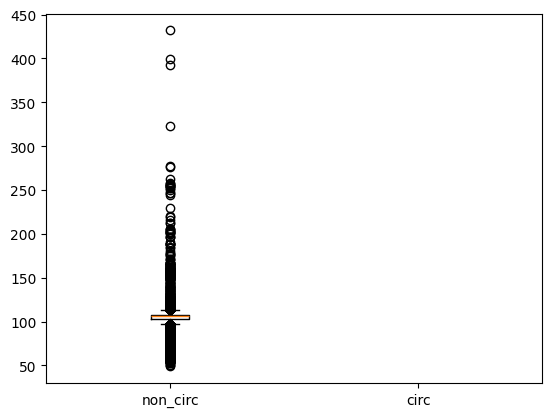

In [19]:
plt.boxplot(data)